In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

import gc
import pickle as pickle


from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf

In [3]:
gc.collect()

items           = pd.read_csv('items.csv',usecols=["item_id", "item_category_id"])
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train.csv.gz')
test            = pd.read_csv('test.csv.gz')

In [4]:
sales_train[['day','month', 'year']] = sales_train['date'].str.split('.', expand=True).astype(int)
sales_train = sales_train[sales_train['year'].isin([2013]) == False]
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id'))
sales_train.reset_index(inplace=True)

In [5]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
max_sales=1000
sums = sales_train.groupby('item_id')['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day":"item_total_sales"}).sort_values(by='item_total_sales')

ids_keep = sums[(sums['item_total_sales'] > 0) & (sums['item_total_sales'] < max_sales)]['item_id'].unique()

In [7]:
#train_item_ids = sales_train['item_id'].unique()
#train_item_ids = np.setdiff1d(train_item_ids, ids_reject)
train_item_ids = ids_keep
train_shop_ids = sales_train['shop_id'].unique()
test_item_ids = test['item_id'].unique()
test_shop_ids = test['shop_id'].unique()
train_blocks = sales_train['date_block_num'].unique()

all_item_ids = np.unique(np.append(test_item_ids,train_item_ids))
all_shop_ids = np.unique(np.append(train_shop_ids,test_shop_ids))


In [8]:
combinations = []

for dbn in range(np.min(train_blocks), np.max(train_blocks)+1):
    sales = sales_train[sales_train.date_block_num==dbn]
    #item_ids = np.intersect1d(sales.item_id.unique(), test_item_ids)
    item_ids = all_item_ids
    #dbn_combos = list(product(sales.shop_id.unique(), item_ids, [dbn]))
    dbn_combos = list(product(all_shop_ids, item_ids, [dbn]))
    for combo in dbn_combos:
        combinations.append(combo)
        
all_combos = pd.DataFrame(np.unique(np.vstack([combinations]), axis=0), columns=['shop_id','item_id','date_block_num'])

In [9]:
ys = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_item_cnt_block"})

training = all_combos.merge(ys, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)


training['shop_item_cnt_block'] = training['shop_item_cnt_block'].clip(0,20).astype('int8')

training = training.set_index('item_id').join(items.set_index('item_id'))
training.reset_index(inplace=True)

for col in ['item_id', 'shop_id', 'item_category_id']:
    training[col] = pd.to_numeric(training[col], downcast='unsigned')

In [10]:
dates = sales_train[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
training['month'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['month']), downcast='unsigned')
training['year'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['year']), downcast='unsigned')



In [11]:
training = training[(~training['date_block_num'].isin([22,23]))]

In [12]:
ys = sales_train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"item_cnt_block"})

training = training.merge(ys, on=['item_id', 'date_block_num'], how='left').fillna(0)

ys = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_cnt_block"})

training = training.merge(ys, on=['shop_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"category_cnt_block"})


training = training.merge(ys, on=['item_category_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['shop_id', 'item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_category_cnt_block"})

training = training.merge(ys, on=['shop_id', 'item_category_id', 'date_block_num'], how='left').fillna(0)


In [13]:
training['item_cnt_block_mean'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.mean)
training['item_cnt_block_min'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.min)
training['item_cnt_block_max'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.max)
training['item_cnt_block_std'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.std)
training['item_cnt_block_med'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.median)

In [14]:
training['shop_cnt_block_mean'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.mean)
training['shop_cnt_block_min'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.min)
training['shop_cnt_block_max'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.max)
training['shop_cnt_block_std'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.std)
training['shop_cnt_block_med'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.median)

In [15]:
training['category_cnt_block_mean'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.mean)
training['category_cnt_block_min'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.min)
training['category_cnt_block_max'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.max)
training['category_cnt_block_std'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.std)
training['category_cnt_block_med'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.median)

In [16]:
training['shop_category_cnt_block_mean'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.mean)
training['shop_category_cnt_block_min'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.min)
training['shop_category_cnt_block_max'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.max)
training['shop_category_cnt_block_std'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.std)
training['shop_category_cnt_block_med'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.median)

In [17]:
training['shop_item_cnt_block_mean'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.mean)
training['shop_item_cnt_block_min'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.min)
training['shop_item_cnt_block_max'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.max)
training['shop_item_cnt_block_std'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.std)
training['shop_item_cnt_block_med'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.median)

In [18]:

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training.sample(10)

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,month,year,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med,shop_item_cnt_block_mean,shop_item_cnt_block_min,shop_item_cnt_block_max,shop_item_cnt_block_std,shop_item_cnt_block_med
4476761,5247,12,13,0,24,2,2014,0.0,1947.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1825.4,1051.0,3400.0,721.055640,1842.5,107.2,0.0,740.0,233.005102,0.0,5.1,0.0,34.0,10.889739,0.0,0.0,0,0,0.000000,0.0
15941850,18902,58,24,0,40,1,2015,0.0,2519.0,15109.0,738.0,0.1,0.0,1.0,0.300278,0.0,1807.2,1319.0,2519.0,419.770861,1699.5,10174.3,6779.0,15109.0,2444.991387,9293.5,513.3,276.0,738.0,144.252382,511.5,0.0,0,0,0.000000,0.0
548964,602,20,16,0,78,5,2014,1.0,0.0,77.0,0.0,0.2,0.0,1.0,0.400371,0.0,326.1,0.0,3261.0,978.302819,0.0,86.9,41.0,138.0,28.023132,87.5,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0.000000,0.0
5379467,6387,59,19,0,19,8,2014,10.0,1244.0,7439.0,112.0,3.1,0.0,17.0,5.490521,0.0,1264.5,1082.0,1491.0,135.336453,1219.5,6585.4,4369.0,9282.0,1523.468715,6006.0,76.2,39.0,112.0,19.535626,75.5,0.0,0,0,0.000000,0.0
3459499,4056,16,33,0,24,10,2015,5.0,963.0,1197.0,8.0,0.5,0.0,5.0,1.501391,0.0,1193.1,963.0,1698.0,195.684212,1150.5,1142.9,749.0,1692.0,289.225084,1120.5,13.0,4.0,26.0,6.118041,11.5,0.0,0,0,0.000000,0.0
16322286,19337,16,18,0,49,7,2014,5.0,1371.0,793.0,3.0,6.3,3.0,10.0,2.240378,6.0,1523.0,1232.0,1913.0,193.002111,1535.0,806.0,617.0,958.0,97.575177,787.5,4.3,1.0,10.0,2.759525,3.5,0.0,0,0,0.000000,0.0
11946186,14227,19,18,4,30,7,2014,139.0,1767.0,10456.0,283.0,128.9,94.0,197.0,30.139213,125.5,1998.0,1703.0,2596.0,256.586008,1927.0,12410.6,10130.0,14883.0,1725.857068,11893.5,330.9,257.0,479.0,72.332019,284.0,3.7,0,11,2.945807,4.0
16761606,19828,2,18,0,37,7,2014,3.0,838.0,5647.0,12.0,1.2,0.0,3.0,1.078032,1.0,910.8,791.0,990.0,56.382429,915.5,6260.6,4971.0,7704.0,898.538132,6104.0,27.7,12.0,44.0,9.338921,26.0,0.0,0,0,0.000000,0.0
3164177,3702,48,31,0,21,8,2015,0.0,1308.0,201.0,8.0,0.4,0.0,1.0,0.490352,0.0,1149.0,990.0,1413.0,116.172621,1106.5,219.1,94.0,394.0,88.926353,205.5,5.6,0.0,12.0,3.074624,5.5,0.0,0,0,0.000000,0.0
16040422,19007,17,14,0,37,3,2014,0.0,1396.0,6322.0,102.0,0.0,0.0,0.0,0.000000,0.0,1222.3,989.0,1474.0,159.136909,1193.0,6260.6,4971.0,7704.0,898.538132,6104.0,111.3,59.0,155.0,24.299113,110.5,0.0,0,0,0.000000,0.0


In [19]:
features = [
    
    'item_cnt_block', 'shop_cnt_block',
       'category_cnt_block', 'shop_category_cnt_block',
       'item_cnt_block_mean', 'item_cnt_block_min', 'item_cnt_block_max',
       'item_cnt_block_std', 'item_cnt_block_med', 'shop_cnt_block_mean',
       'shop_cnt_block_min', 'shop_cnt_block_max', 'shop_cnt_block_std',
       'shop_cnt_block_med', 'category_cnt_block_mean',
       'category_cnt_block_min', 'category_cnt_block_max',
       'category_cnt_block_std', 'category_cnt_block_med',
       'shop_category_cnt_block_mean', 'shop_category_cnt_block_min',
       'shop_category_cnt_block_max', 'shop_category_cnt_block_std',
       'shop_category_cnt_block_med','shop_item_cnt_block_std'

]

In [20]:
training.fillna(0,inplace=True)

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 


training[features] = StandardScaler().fit_transform(training[features])



In [22]:
training[features] = training[features].apply(pd.to_numeric, downcast='float')

In [23]:
training[features].sample(10)

,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med,shop_item_cnt_block_std
15879631,-0.096362,-0.225594,1.211402,0.151278,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,-0.274792,-0.297482,-0.348120,-0.342238,-0.228043,0.902078,0.715022,1.083516,1.346057,0.842288,0.195858,0.312943,0.092732,-0.135231,0.243384,-0.274340
229249,-0.096362,-0.402084,-0.914107,-0.466089,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,-0.090170,-0.183024,-0.218470,-0.141709,-0.080399,-0.940938,-0.901666,-1.008421,-1.057520,-0.928765,-0.487967,-0.429710,-0.500155,-0.472796,-0.484846,-0.274340
10508076,0.200229,-1.053644,0.215142,-0.466089,0.295551,0.320050,0.160573,0.081963,0.278127,-1.032009,-0.979594,-0.559059,0.088113,-1.074470,0.300366,0.263617,0.268374,0.257191,0.285724,-0.450814,-0.429710,-0.248932,-0.079528,-0.484846,-0.274340
16252414,-0.096362,-0.794918,0.699282,-0.379944,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,-0.835327,-0.683394,-0.999457,-0.824787,-0.789968,0.902078,0.715022,1.083516,1.346057,0.842288,-0.400104,-0.375204,-0.399666,-0.353695,-0.403640,-0.274340
15838841,-0.096362,-0.066183,0.134570,-0.188513,-0.012912,-0.036045,-0.016121,-0.004927,-0.008869,-0.098054,0.037387,-0.351722,-0.562269,-0.045341,0.183808,0.277647,0.046024,-0.188997,0.225913,-0.142540,-0.136737,-0.104897,-0.119672,-0.144307,-0.274340
15309661,-0.017271,-1.053644,0.134570,-0.466089,-0.006157,-0.036045,0.015060,0.018877,0.003089,-0.719770,-0.979594,-0.807555,-0.150342,-0.600525,0.183808,0.277647,0.046024,-0.188997,0.225913,-0.340859,-0.429710,-0.289127,-0.142178,-0.330293,-0.274340
12123078,-0.076589,-0.362864,0.269151,0.041205,0.133439,-0.006371,0.087817,0.102096,0.170504,-0.376873,-0.241800,-0.526132,-0.581739,-0.351080,0.902078,0.715022,1.083516,1.346057,0.842288,0.341962,0.292503,0.199921,0.132858,0.434610,1.239417
10234144,-0.096362,-0.290749,-0.801837,-0.466089,-0.105226,-0.036045,-0.140845,-0.162090,-0.080618,-0.217316,-0.163689,-0.405228,-0.495034,-0.170738,-0.828105,-0.791355,-0.912868,-0.982907,-0.805470,-0.483950,-0.429710,-0.490106,-0.456263,-0.482226,-0.274340
625887,-0.096362,-0.820853,-0.930929,-0.466089,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,-1.048652,-0.979594,-1.039587,-0.493881,-1.074470,-0.958887,-0.924406,-1.021871,-1.054014,-0.947993,-0.488971,-0.429710,-0.503505,-0.479821,-0.484846,-0.274340
5266587,0.457273,0.014155,1.048487,0.290066,0.948503,0.616796,0.711440,0.760185,0.887994,0.224360,0.273264,-0.022452,-0.281978,0.255004,0.890351,1.098450,0.582494,-0.072385,0.972057,0.400705,0.626356,0.196571,-0.158595,0.466044,1.508017


In [24]:
a = training[['shop_item_cnt_block'] + ['date_block_num','item_id', 'shop_id', 'year'] + features].sort_values(by=["date_block_num"]).groupby(["item_id", "shop_id", "year"])#['item_id_mean_encoding']#[features+['item_cnt_block']]

In [25]:
#groups
lstm_data = []
lstm_y = []

for name, group in a:
    #print(group.values)
    steps = []
    ys = []
    #print("group.values",group.values)
    for step in group.values:
        #print(step)
        #print("step", len(step))
        #step is np.array 
        #step[4:] is np.array print(type(step[4:]))
        steps.append(step[5:])
        #print(step[9])
        #print(step[0])
        ys.append(step[0])
    #remove last
    #print(type(steps[0:8]))
    #jan to sept, y = oct
    lstm_data.append(np.array(steps[0:8]))
    #remove first
    #print(ys)
    #preditct for setptember
    lstm_y.append(ys[-1])
    
lstm_y = np.array([np.array([y]) for y in lstm_y])

In [26]:
small_data = np.array(lstm_data)
small_y = np.array(lstm_y)

In [27]:
print(len(lstm_y))

print(len([y for y in lstm_y if y == 0]))

zeros_indices = {}
for idx,y in enumerate(lstm_y):
    
    if y == 0:
        zeros_indices[idx] = True

1873908
1801396


In [31]:
lstm_data_no_zeros = []
lstm_y_no_zeros = []
for idx,sample in enumerate(lstm_data):
    if idx not in zeros_indices:
        lstm_data_no_zeros.append(sample)
        lstm_y_no_zeros.append(lstm_y[idx])

In [32]:
lstm_zeros = []
for idx,y in enumerate(lstm_y):
    if idx in zeros_indices:
        lstm_zeros.append(idx)

In [33]:
#print(len(lstm_data_no_zeros))

for zero_idx in np.random.choice(lstm_zeros,35000,replace=False):
    lstm_data_no_zeros.append(lstm_data[zero_idx])
    lstm_y_no_zeros.append(lstm_y[zero_idx])

In [34]:
small_data = np.array(lstm_data_no_zeros)
small_y = np.array(lstm_y_no_zeros)

In [35]:
from sklearn.model_selection import train_test_split

train_data, val_data, y_train, y_val = train_test_split(small_data, small_y, test_size=0.1, random_state=42)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 64)             23040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 64)             256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 56,641
Trainable params: 56,385
Non-trainable params: 256
_________________________________________________________________
Train on 96760 samples, validate on 10752 samples
Epoch 1/100
96760/96760 [==============================] - 71s 736us/step - loss: 1.92

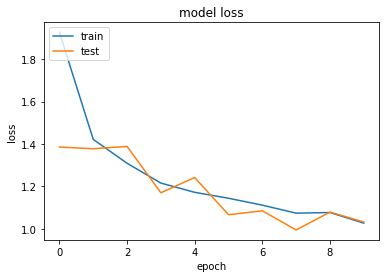

best rmse val: 1.0158541384655828


In [36]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization


#x_train_scaled = MinMaxScaler().fit_transform(x_train[features])


#x_reshaped = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 10, x_train_scaled.shape[1]))
    
#x_val_scaled_reshaped = np.reshape(x_val_scaled, (x_val_scaled.shape[0], 1, x_val_scaled.shape[1]))


callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]

dropout=0

my_model = Sequential()
#bi directional?
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 4, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
my_model.add(BatchNormalization())
#my_model.add(Dropout(dropout))
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 48, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
my_model.add(BatchNormalization())
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 4, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()


#lstmd_dataa = np.array(np.array(lstm_data)).reshape(271148,8,51)
#print(lstmd_dataa.shape)
#print(lstmd_dataa)
#lstm_yy = np.array([np.array([y]) for y in lstm_y[0:100]])
#print(lstm_yy.shape)
#print(lstm_yy)

history = my_model.fit(train_data, y_train, batch_size=64, epochs=100,
                      validation_data=(val_data,y_val), callbacks=callbacks
                      )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

import math
print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [37]:
training_test = training[(training['shop_id'].isin(test['shop_id'].unique())) & (training['item_id'].isin(test['item_id'].unique()))]

In [41]:
train_data.shape

(96760, 8, 25)

In [38]:
test_lstm_data = []

for index, row in test.iterrows():
    if index % 10000 == 0:
        print(index)
    line = training_test[(training_test['year'] == 2015) & (training_test['shop_id'] == row['shop_id']) & (training_test['item_id'] == row['item_id'])].sort_values(by=['date_block_num'])[features].values
    test_lstm_data.append(line[1:22])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000


In [44]:
test_lstm_data = [sample[1:9] for sample in test_lstm_data]

In [49]:
len(test_lstm_data)

214200

In [45]:
preds = my_model.predict(np.array(test_lstm_data),batch_size=len(test_lstm_data))
preds.clip(0,20,out=preds)

array([[1.4426848],
       [0.       ],
       [1.1061953],
       ...,
       [0.8175033],
       [0.       ],
       [0.       ]], dtype=float32)

In [46]:

print(np.mean(preds))
print(np.max(preds))

0.5007466
20.0


In [47]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds

submission.to_csv('submission.csv', index=False)

In [66]:
bestpreds = pd.read_csv('submissionbest.csv')['item_cnt_month']
print(np.mean(bestpreds))
print(np.max(bestpreds))

0.3542884257097005
16.49019305497366


In [ ]:
lr_preds = pd.read_csv('lr110.csv')['item_cnt_month']
lg_preds = pd.read_csv('lg110.csv')['item_cnt_month']
#cb_preds = pd.read_csv('cb102.csv')['item_cnt_month']


#preds = np.mean(np.array([lr_preds, lg_preds]),axis=0)

preds = (lg_preds * 0.50) + (lr_preds * 0.50)